In [1]:
import json
import os
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
from sklearn.utils import shuffle
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
import itertools
from sklearn.model_selection import train_test_split 

In [2]:
IMG_WIDTH = 224 
IMG_HEIGHT = 224
MAX_FRAMES = 60
EPOCHS = 20
BATCH_SIZE = 400
video_per_word = 80
words = ['hello', 'we', 'team', 'university', 'zagazig', 'goal', 'communication', 'easy', 
         'help', 'deaf', 'and', 'speaking', 'college', 'computer', 'information', 'science', 
         'disability','rehabilitation', 'you', 'me', 'name', 'question', 'clear', 'yes', 'what']
NO_OF_WORDS = len(words)

In [3]:
def get_videos_paths(path, classes_, video_per_class=0):
    videos_paths = []
    for dir_name in classes_:
        dir_path = os.path.join(path, dir_name)
        all_class_videos_path = []
        
        for video_name in os.listdir(dir_path):
            abs_path = os.path.join('/kaggle/input/wordsarabicsl/WordsArabicSL', dir_name, video_name)
            video = cv2.VideoCapture(abs_path)
            total_no_of_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_no_of_frames >= 60:
                all_class_videos_path.append(abs_path)
                
        all_class_videos_path = shuffle(all_class_videos_path, random_state=42)
        videos_to_use = all_class_videos_path if video_per_class==0 else all_class_videos_path[:video_per_class]
        for video_path in videos_to_use:
            videos_paths.append([video_path ,classes_.index(dir_name)]) 
        print(classes_.index(dir_name), len(videos_to_use))
    videos_paths = shuffle(videos_paths, random_state=24)
    return videos_paths

In [4]:
# Generator / Iterator 

def load_videos(paths_list, max_frames, resize=(IMG_WIDTH, IMG_HEIGHT), start=0):
    paths = itertools.cycle(paths_list)
    while True:
        try:
            path, class_ = next(paths)
        except:
            break

        cap = cv2.VideoCapture(path)
        frames = []
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    raise Exception("Error")
                frame = cv2.resize(frame, resize)
                frame = frame[:, :, [2, 1, 0]]
                frames.append(frame/255)

                if len(frames) == max_frames:
                    break
        finally:
            cap.release()

        frames = np.expand_dims(frames, axis=0)
        cate = [1 if c == class_ else 0 for c in range(NO_OF_WORDS)]
        cate = np.expand_dims(cate, axis=0)

        yield frames, cate

In [5]:
# paths

In [6]:
paths = get_videos_paths("/kaggle/input/wordsarabicsl/WordsArabicSL", words, video_per_word)

n_videos = len(paths)

0 80
1 79
2 80
3 80
4 80
5 80
6 80
7 80
8 80
9 80
10 78
11 79
12 80
13 78
14 80
15 80
16 77
17 80
18 78
19 80
20 80
21 77
22 80
23 80
24 73


In [7]:
print(n_videos)

1979


In [8]:
X = [it[0] for it in paths]
y = [it[1] for it in paths]
print(len(X))
print(len(y))

1979
1979


In [9]:
train_paths, other_paths, train_classes, other_classes = train_test_split(X,y, test_size=0.30, random_state=42, stratify=y)

val_paths, test_paths, val_classes, test_classes = train_test_split(other_paths,other_classes, test_size=0.50, random_state=42, stratify=other_classes)

train_set = [[train_paths[i],train_classes[i]] for i in range(len(train_paths))]
val_set = [[val_paths[i],val_classes[i]] for i in range(len(val_paths))]
test_set = [[test_paths[i],test_classes[i]] for i in range(len(test_paths))]

n_train = len(train_set)
n_val = len(val_set)
n_test = len(test_set)

In [10]:
print(n_train)
print(n_val)
print(n_test)

1385
297
297


In [17]:
train_gen = load_videos(train_set, MAX_FRAMES)
val_gen = load_videos(val_set, MAX_FRAMES)
test_gen = load_videos(test_set, MAX_FRAMES)

In [21]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPooling3D, Conv3D, ConvLSTM3D, LSTM
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
hub_url = "https://tfhub.dev/tensorflow/movinet/a1/base/kinetics-600/classification/3"

encoder = hub.KerasLayer(hub_url, trainable=False)

2023-02-04 20:55:19.326419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:55:19.428485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:55:19.429317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:55:19.430890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [25]:
inputs = tf.keras.layers.Input(
    shape=[MAX_FRAMES, IMG_WIDTH, IMG_HEIGHT, 3],
    dtype=tf.float32,
    name='image')

# [batch_size, 600]
x = encoder(dict(image=inputs))

# x = Dense(64, activation = 'relu')(x)

outputs = Dense(NO_OF_WORDS, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name='movinet')
model.summary()

Model: "movinet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 60, 224, 224, 3)] 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 600)               4717912   
_________________________________________________________________
dense (Dense)                (None, 25)                15025     
Total params: 4,732,937
Trainable params: 15,025
Non-trainable params: 4,717,912
_________________________________________________________________


In [26]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
es = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [27]:
train_gen = load_videos(train_set, MAX_FRAMES)
val_gen = load_videos(val_set, MAX_FRAMES)
test_gen = load_videos(test_set, MAX_FRAMES)

In [28]:
history = model.fit(train_gen, steps_per_epoch=n_train, validation_data=val_gen,
                    validation_steps=n_val, epochs=15, batch_size=BATCH_SIZE, verbose=1, callbacks=[es])

2023-02-04 20:55:49.875947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-02-04 20:56:04.050104: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f3aa43598e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-04 20:56:04.050170: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-02-04 20:56:05.999394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-02-04 20:56:10.741178: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1385/1385 [==============================] - 1568s 1s/step - loss: 1.8295 - accuracy: 0.5090 - precision: 0.7045 - recall: 0.3805 - val_loss: 1.2125 - val_accuracy: 0.6566 - val_precision: 0.7173 - val_recall: 0.5724
Epoch 2/15
1385/1385 [==============================] - 1531s 1s/step - loss: 0.7168 - accuracy: 0.7747 - precision: 0.8412 - recall: 0.7040 - val_loss: 1.0342 - val_accuracy: 0.7104 - val_precision: 0.7557 - val_recall: 0.6667
Epoch 3/15
1385/1385 [==============================] - 1524s 1s/step - loss: 0.4890 - accuracy: 0.8542 - precision: 0.8864 - recall: 0.8166 - val_loss: 0.9761 - val_accuracy: 0.7576 - val_precision: 0.7904 - val_recall: 0.7239
Epoch 4/15
1385/1385 [==============================] - 1516s 1s/step - loss: 0.3647 - accuracy: 0.8816 - precision: 0.9104 - recall: 0.8513 - val_loss: 0.9292 - val_accuracy: 0.7710 - val_precision: 0.7936 - val_recall: 0.7508
Epoch 5/15
1385/1385 [==============================] - 1506s 1s/step - loss: 0.3000 - accuracy: 0.

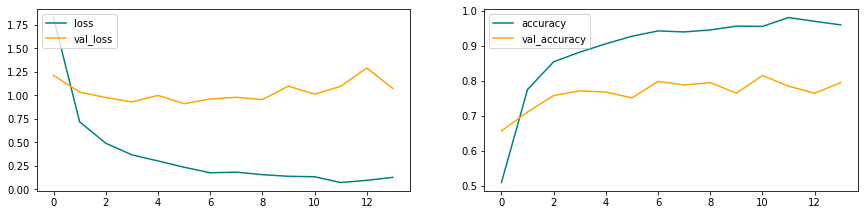

In [29]:
plt.figure(figsize=(400,400))

ax = plt.subplot(100,50,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc="upper left")

ax = plt.subplot(100,50,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.legend(loc="upper left")

plt.show()

# Evaluation

In [30]:
test_results = model.evaluate(test_gen, steps=n_test, batch_size=1, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')
print(f'Test results - Precision: {test_results[2]*100} - Recall: {test_results[3]*100}%')

297/297 [==============================] - 294s 992ms/step - loss: 0.8208 - accuracy: 0.8316 - precision: 0.8526 - recall: 0.8182
Test results - Loss: 0.8208282589912415 - Accuracy: 83.16498398780823%
Test results - Precision: 85.26315689086914 - Recall: 81.81818127632141%


In [35]:
test_gen = load_videos(test_set, MAX_FRAMES)

y_predictions = model.predict(test_gen, steps=n_test, batch_size=1, verbose=1)

297/297 [==============================] - 288s 965ms/step


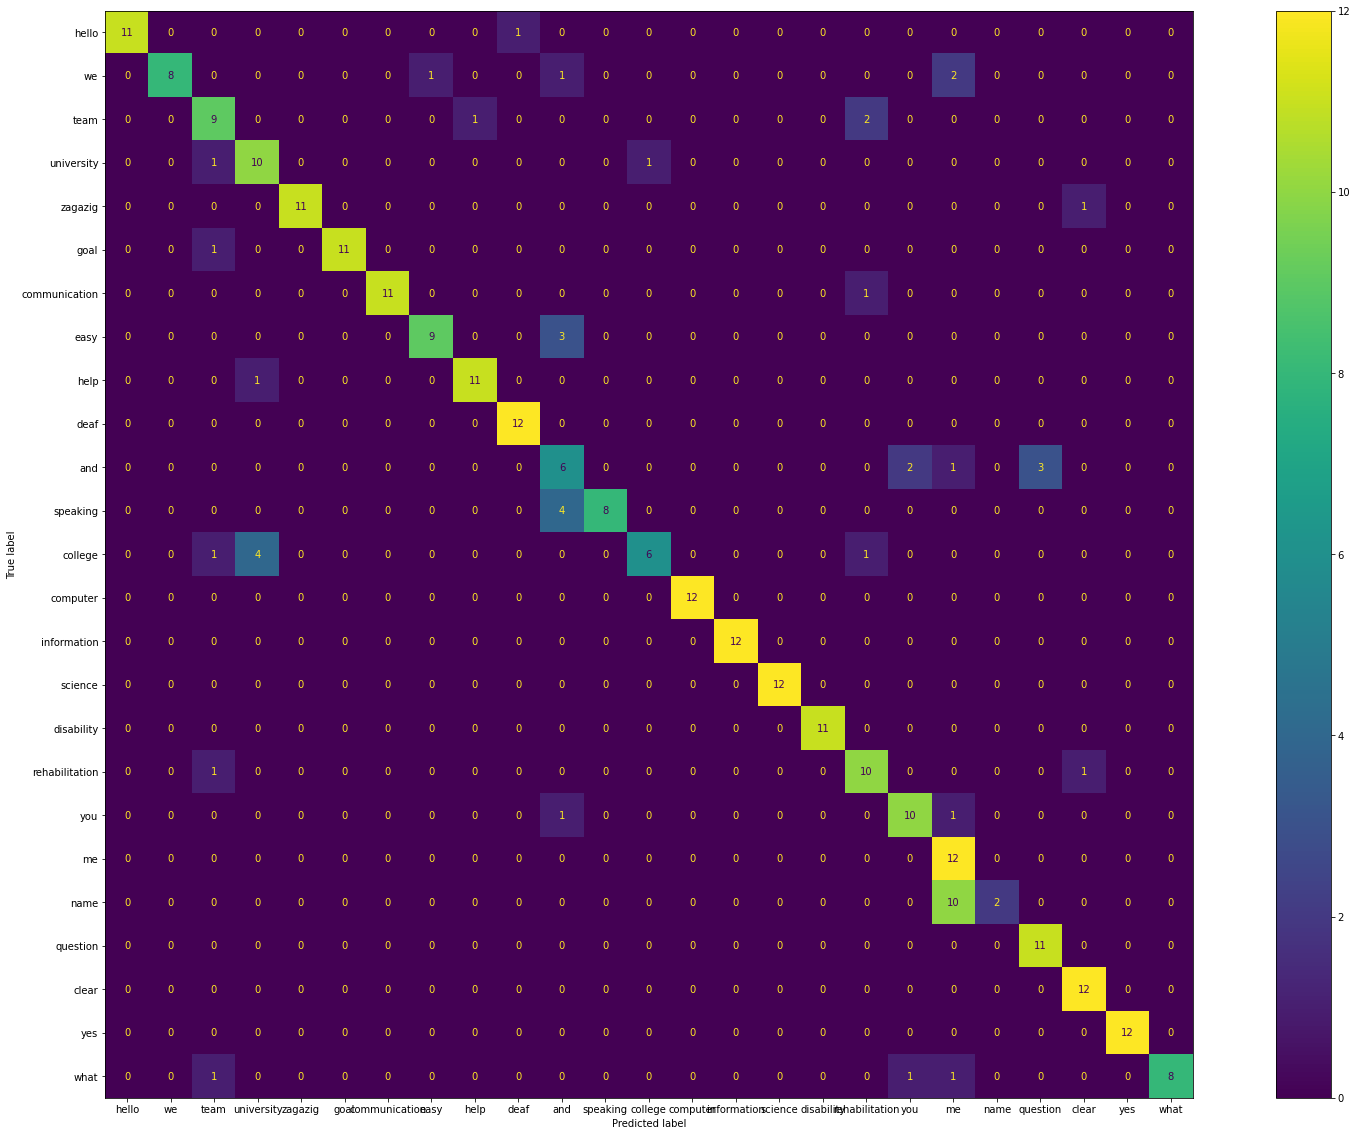

In [51]:
#Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_test = [tp[1] for tp in test_set]
cm=confusion_matrix(y_test,y_predictions.argmax(axis=1))

clss = words
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clss)

plt.rcParams["figure.figsize"] = 30, 20
disp.plot()
plt.show()


In [52]:
#Classification Report

from sklearn.metrics import classification_report

report = classification_report(y_test,y_predictions.argmax(axis=1), target_names=clss)
print(report)

                precision    recall  f1-score   support

         hello       1.00      0.92      0.96        12
            we       1.00      0.67      0.80        12
          team       0.64      0.75      0.69        12
    university       0.67      0.83      0.74        12
       zagazig       1.00      0.92      0.96        12
          goal       1.00      0.92      0.96        12
 communication       1.00      0.92      0.96        12
          easy       0.90      0.75      0.82        12
          help       0.92      0.92      0.92        12
          deaf       0.92      1.00      0.96        12
           and       0.40      0.50      0.44        12
      speaking       1.00      0.67      0.80        12
       college       0.86      0.50      0.63        12
      computer       1.00      1.00      1.00        12
   information       1.00      1.00      1.00        12
       science       1.00      1.00      1.00        12
    disability       1.00      1.00      1.00  

In [53]:
model_name = f'Ar_{NO_OF_WORDS}w_{video_per_word}v_mn6_{int(test_results[1]*100)}aa'
model.save(f"{model_name}.h5")

In [55]:
import tensorflow as tf
from tensorflow.keras.models import load_model

keras_model = load_model(f'/kaggle/working/{model_name}.h5', 
                         custom_objects={'KerasLayer': hub.KerasLayer})
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, 
  tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()
with open(f'{model_name}.tflite', 'wb') as f:
    f.write(tflite_model)

2023-02-05 03:16:51.365107: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-02-05 03:17:14.428304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 03:17:14.430717: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-05 03:17:14.430941: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-02-05 03:17:14.433753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 03:17:14.434931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne